# Homework 4 (Due Tuesday, May 10th at 7pm PST)

> This homework is co-completed by **Siqin Yang** (7374355500), **Ningxi Wang** (3605565772) and **Yi Gao** (5948798200) :)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
from typing import Dict, List
from matplotlib import pyplot as plt

import spacy
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Masking
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import LSTM

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

## Build A Classification Model w/ BBC News / BBC Sport (7pts)

Build a classification model using the **BBC News or BBC Sport articles dataset** that is able to predict on a hold-out set the sentiment of the reviews with at minimum 92% accuracy (do not round). You can pick ONE of the topics to be your positive class, and label everything else to be negative.

You may incorporate as many samples as you wish. However, **the class balance in your training and test set must be 50/50**.

You will likely need to include some preprocessing techniques that we have learned about so far in this course.

If you are unable to achieve 92% accuracy, then please show in this notebook at least **3 different models**:
* one count vectorizer model
* one model that uses `word2vec`
* one sequential / transformer-based / deep-learning with embeddings model

Focus on:
* feature preprocessing steps (what we've learned earlier in this course)
* proper implementation of the models
* using the right metrics to evaluate your model performance

**Make sure to cite your sources if you use other people's code or ideas.**

In [25]:
data_orig = pd.read_csv('../datasets/bbc-text.csv')
data_orig.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [26]:
data_orig.shape

(2225, 2)

### data preprocess

#### encode labels

In [27]:
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(data_orig['category']))
labels

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [28]:
sum(labels)

array([510., 386., 417., 511., 401.], dtype=float32)

to get maxmimum sampling w.r.t. 50/50 balance, we choose the first topic

In [29]:
labels = labels.T[3]
labels

array([0., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [30]:
sum(labels) / len(labels)

0.22966292134831462

In [32]:
data_orig['label'] = labels
data_orig

,category,text,label
0,tech,tv future in the hands of viewers with home th...,0.0
1,business,worldcom boss left books alone former worldc...,0.0
2,sport,tigers wary of farrell gamble leicester say ...,1.0
3,sport,yeading face newcastle in fa cup premiership s...,1.0
4,entertainment,ocean s twelve raids box office ocean s twelve...,0.0
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,0.0
2221,politics,kilroy unveils immigration policy ex-chatshow ...,0.0
2222,entertainment,rem announce new glasgow concert us band rem h...,0.0
2223,politics,how political squabbles snowball it s become c...,0.0


#### sampling

In [36]:
data = data_orig.groupby(['label'], group_keys=False).apply(lambda x: x.sample(n=int(sum(labels)), 
                                                                               random_state=41))
data

,category,text,label
370,tech,text messages aid disaster recovery text messa...,0.0
972,tech,seamen sail into biometric future the luxury c...,0.0
2186,business,battered dollar hits another low the dollar ha...,0.0
412,politics,blair labour s longest-serving pm tony blair h...,0.0
937,tech,the force is strong in battlefront the warm re...,0.0
...,...,...,...
334,sport,melzer shocks agassi second seed andre agassi ...,1.0
2091,sport,collins named uk athletics chief uk athletics ...,1.0
1739,sport,collins to compete in birmingham world and com...,1.0
1831,sport,agassi fear for melbourne andre agassi s invol...,1.0


In [37]:
sum(data['label']) / len(data['label'])

0.5

#### text preprocess

##### RegEx cleaning

In [38]:
data['text_orig'] = data['text']

In [39]:
data['text'] = data['text'].\
                apply(urls).\
                apply(hashtags).\
                apply(numbers).\
                apply(currency_symbols).\
                apply(emojis).\
                apply(emails)

In [40]:
data['text'] = data['text'].apply(punctuation)

In [41]:
data['text']

370     text messages aid disaster recovery text messa...
972     seamen sail into biometric future the luxury c...
2186    battered dollar hits another low the dollar ha...
412     blair labour s longest serving pm tony blair h...
937     the force is strong in battlefront the warm re...
                              ...                        
334     melzer shocks agassi second seed andre agassi ...
2091    collins named uk athletics chief uk athletics ...
1739    collins to compete in birmingham world and com...
1831    agassi fear for melbourne andre agassi s invol...
1946    wada will appeal against ruling the world anti...
Name: text, Length: 1022, dtype: object

In [44]:
data['text'] = data['text'].str.replace("  ", " ", regex=True)
data['text'] = data['text'].str.replace("EMOJI", "", regex=True)

##### remove stopwords

In [45]:
docs = data['text']
labels = data['label']

In [46]:
nlp = spacy.load('en_core_web_sm', disable=["ner", "tagger"])
# words_set = set(nlp.vocab.strings)
docs_cleaned = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

/Users/antheayang/opt/anaconda3/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [48]:
docs_cleaned = [re.sub(' +', ' ', i) for i in docs_cleaned]

In [49]:
docs_cleaned = [re.sub(r'^(.+?)\1+', r'\1', i) for i in docs_cleaned]

#### tokenization

In [50]:
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs_cleaned)

In [51]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# integer encode the documents
docs_encoded = integer_encode_documents(docs_cleaned, tokenizer)

<AxesSubplot:>

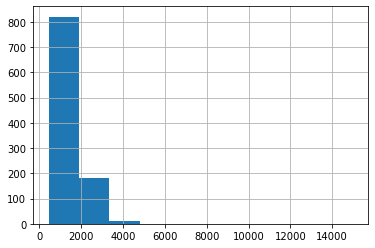

In [53]:
pd.Series(docs_cleaned).str.len().hist()

In [52]:
pd.Series(docs_cleaned).str.len().describe()

count     1022.000000
mean      1409.400196
std        916.524142
min        442.000000
25%        899.250000
50%       1204.000000
75%       1711.750000
max      14985.000000
dtype: float64

since 75% of the reviews are less than 1711 words, set `MAX_SEQUENCE_LENGTH` as 1700

In [54]:
MAX_SEQUENCE_LENGTH = 1700

In [55]:
docs_padded = pad_sequences(docs_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
docs_padded

array([[1014,  882,  717, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [   1,  432, 1183, ...,    0,    0,    0],
       ...,
       [1008,  651,  617, ...,    0,    0,    0],
       [1060,  864, 1592, ...,    0,    0,    0],
       [   1,  634, 1208, ...,    0,    0,    0]], dtype=int32)

In [56]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 25248 unique tokens.


In [71]:
data_docs = pd.DataFrame(docs_padded)
data_docs

,0,1,2,3,4,5,6,7,8,9,...,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699
0,1014,882,717,1714,1440,1014,3730,118,1,4098,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,166,4939,1,1,3197,1,319,...,0,0,0,0,0,0,0,0,0,0
2,1,432,1183,460,432,1389,9,67,460,928,...,0,0,0,0,0,0,0,0,0,0
3,115,65,3,4111,2401,3200,466,115,65,75,...,0,0,0,0,0,0,0,0,0,0
4,687,261,4485,3203,4115,4952,200,3000,4485,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2643,4006,1060,25,357,1964,1060,917,1,350,...,0,0,0,0,0,0,0,0,0,0
1018,1008,681,27,478,170,27,478,814,364,9,...,0,0,0,0,0,0,0,0,0,0
1019,1008,651,617,13,4884,1042,5,125,1406,1008,...,0,0,0,0,0,0,0,0,0,0
1020,1060,864,1592,1964,1060,3,4156,256,53,683,...,0,0,0,0,0,0,0,0,0,0


In [72]:
data_docs = pd.concat([data_docs.reset_index(drop=True),
                       data[['text', 'label']].reset_index(drop=True)], 
                      axis=1, ignore_index=True)

In [73]:
mp = {data_docs.columns[-1]: 'label',
     data_docs.columns[-2]: 'text'}
data_docs.rename(columns=mp, errors="raise", inplace=True)
data_docs.head()

,0,1,2,3,4,5,6,7,8,9,...,1692,1693,1694,1695,1696,1697,1698,1699,text,label
0,1014,882,717,1714,1440,1014,3730,118,1,4098,...,0,0,0,0,0,0,0,0,text messages aid disaster recovery text messa...,0.0
1,1,1,1,166,4939,1,1,3197,1,319,...,0,0,0,0,0,0,0,0,seamen sail into biometric future the luxury c...,0.0
2,1,432,1183,460,432,1389,9,67,460,928,...,0,0,0,0,0,0,0,0,battered dollar hits another low the dollar ha...,0.0
3,115,65,3,4111,2401,3200,466,115,65,75,...,0,0,0,0,0,0,0,0,blair labour s longest serving pm tony blair h...,0.0
4,687,261,4485,3203,4115,4952,200,3000,4485,1,...,0,0,0,0,0,0,0,0,the force is strong in battlefront the warm re...,0.0


### modeling

In [78]:
X_train, X_test, y_train, y_test = train_test_split(docs_padded, labels, test_size=0.2, 
                                                    stratify=labels, random_state=41)
X_train.shape, X_test.shape

((817, 1700), (205, 1700))

In [80]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.5006119951040392, 0.4975609756097561)

#### pre-trained embedding

Reference: `Using_RNNs_and_LSTMs`

https://colab.research.google.com/drive/1G6bxy1OlHPeVo6zAs8TxvN5du9PHhZQf?usp=sharing

In [81]:
def load_glove_vectors() -> Dict:
    embeddings_index = {}
    with open('../datasets/glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [82]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

#### LSTM

as the text is rather lengthy, choose the LSTM model

Reference: `Using_RNNs_and_LSTMs`

https://colab.research.google.com/drive/1G6bxy1OlHPeVo6zAs8TxvN5du9PHhZQf?usp=sharing

In [83]:
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, 
                        weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
            optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [87]:
model = make_lstm_classification_model()
model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1700, 100)         2524800   
_________________________________________________________________
masking_2 (Masking)          (None, 1700, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,542,369
Trainable params: 17,569
Non-trainable params: 2,524,800
_________________________________________________________________


##### training

In [88]:
# fit the model
es = EarlyStopping(monitor='val_loss', mode='min', patience=7, verbose=1)
log = model.fit(X_train, y_train, batch_size=64, 
                validation_split=0.1, epochs=50, verbose=1, 
                        callbacks=[es],
                 )

Train on 735 samples, validate on 82 samples
Epoch 1/50
735/735 [==============================] - 51s 69ms/step - loss: 0.6804 - acc: 0.5959 - val_loss: 0.5625 - val_acc: 0.7805
Epoch 2/50
735/735 [==============================] - 51s 69ms/step - loss: 0.4651 - acc: 0.8503 - val_loss: 0.3282 - val_acc: 0.9268
Epoch 3/50
735/735 [==============================] - 51s 69ms/step - loss: 0.1932 - acc: 0.9442 - val_loss: 0.0772 - val_acc: 0.9878
Epoch 4/50
735/735 [==============================] - 51s 69ms/step - loss: 0.0626 - acc: 0.9823 - val_loss: 0.1130 - val_acc: 0.9756
Epoch 5/50
735/735 [==============================] - 56s 76ms/step - loss: 0.1237 - acc: 0.9714 - val_loss: 0.0980 - val_acc: 0.9756
Epoch 6/50
735/735 [==============================] - 60s 82ms/step - loss: 0.0692 - acc: 0.9823 - val_loss: 0.0624 - val_acc: 0.9878
Epoch 7/50
735/735 [==============================] - 51s 70ms/step - loss: 0.0445 - acc: 0.9932 - val_loss: 0.0839 - val_acc: 0.9756
Epoch 8/50
735/73

In [89]:
# evaluate the model
loss_tr, acc_tr = model.evaluate(X_train, y_train, verbose=1)
print('TRAIN Accuracy: %f' % (acc_tr*100))

817/817 [==============================] - 21s 26ms/step
TRAIN Accuracy: 99.020809


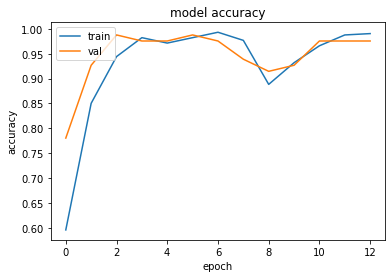

In [91]:
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

##### testing

In [93]:
loss_tt, acc_tt = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (acc_tt*100))

205/205 [==============================] - 6s 27ms/step
Accuracy: 98.536587


## Perform Topic Modelling (3 pts)

Perform topic modelling on the `news_categories.csv` dataset. This dataset is from [News Category Dataset, Akash Gupta](https://www.kaggle.com/datasets/akash14/news-category-dataset). You may use the link to find what each `SECTION` integer maps to in terms of a human-readable category.

**Deliverables**:

    - show the most likely n-grams for a certain topic
    - show the top documents for each topic
    - explain/summarize what the subject each topic is likely to be

### Random Seeds

Make sure to set the random seeds in your notebook so I can run your results and get the same exact output:

In [5]:
from numpy.random import seed
seed(42)

from tensorflow import set_random_seed
set_random_seed(32)

In [6]:
data_news = pd.read_csv('../datasets/news_categories.csv',
                        encoding='cp1252'
#                         encoding = 'unicode_escape'
                       )
data_news.drop_duplicates('STORY', inplace=True)
data_news.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


### Non-Negative Matrix Factorization

ref: `Topic Modelling`
https://colab.research.google.com/drive/1tnH3a_DtbpMlXUr_X09ezOL2c4ekoNfx#scrollTo=m5KWA9b0FShn

#### Vectorize The Corpus

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(3,3), min_df=3,
                            max_df=0.4, stop_words="english")

X_news = vectorizer.fit_transform(data_news['STORY'])
news_terms = vectorizer.get_feature_names_out()
news_tf_idf = pd.DataFrame(X_news.toarray(), columns=news_terms)
print(f"News TF-IDF: {news_tf_idf.shape}")
news_tf_idf.head(5)

News TF-IDF: (7548, 5867)


,000 10 000,000 3gb 32gb,000 6gb 128gb,000 annually 20,000 barrels day,000 base 4gb,000 base variant,000 bringing price,000 buying 81,000 crore disinvestment,...,yuan 30 000,yuan 35 000,yuan 35 500,yuvan shankar raja,z5 pro gt,zaidi short story,zenfone max m1,zenfone max m2,zenfone max pro,zuckerberg said know
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Fit NMF Model

In [8]:
nmf = NMF(n_components=len(set(data_news['SECTION'])))
W_news = nmf.fit_transform(X_news)
H_news = nmf.components_
print(f"Original shape of X news is {X_news.shape}")
print(f"Decomposed W news matrix is {W_news.shape}")
print(f"Decomposed H news matrix is {H_news.shape}")

Original shape of X news is (7548, 5867)
Decomposed W news matrix is (7548, 4)
Decomposed H news matrix is (4, 5867)


#### Report Results For Each Topic

In [9]:
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
    """
    Uses the H matrix (K components x M original features) to identify for each
    topic the most frequent tokens.
    """
    for topic, vector in enumerate(H):
        print(f"TOPIC {topic}\n")
        total = vector.sum()
        top_scores = vector.argsort()[::-1][:num_top_tokens] # positions of sorted order
        token_names = list(map(lambda idx: feature_names[idx], top_scores))
        strengths = list(map(lambda idx: vector[idx] / total, top_scores))

        for strength, token_name in zip(strengths, token_names):
            print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
        print(f"=" * 50)

In [10]:
print(f"News Topics:\n\n")
get_top_tf_idf_tokens_for_topic(H_news, news_tf_idf.columns.tolist(), 10)

News Topics:


TOPIC 0

story published wire (11.5%)

feed modifications text (11.5%)

wire agency feed (11.5%)

published wire agency (11.5%)

agency feed modifications (11.5%)

text headline changed (11.5%)

modifications text headline (11.5%)

said story published (1.4%)

added story published (0.9%)

ahead general election (0.2%)

TOPIC 1

prime minister narendra (12.6%)

minister narendra modi (12.6%)

narendra modi government (0.8%)

national democratic alliance (0.8%)

congress president rahul (0.8%)

president rahul gandhi (0.8%)

model code conduct (0.7%)

narendra modi led (0.6%)

new delhi election (0.6%)

delhi election commission (0.6%)

TOPIC 2

mint india wire (37.9%)

india wire appleapple (2.0%)

artificial intelligence ai (1.6%)

india wire data (1.5%)

mate 20 pro (1.2%)

india wire asus (1.1%)

step right direction (1.0%)

india wire google (0.9%)

6t priceoneplus 6t (0.8%)

india wire oneplus (0.8%)

TOPIC 3

bharatiya janata party (6

#### Get the Top Documents For Each Topic

In [11]:
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
    """
    Uses the W matrix (N docs x K components/topics) to identify for each
    topic the most top documents.
    """
    sorted_docs = W.argsort(axis=0)[::-1]
    top_docs = sorted_docs[:num_docs].T
    per_document_totals = W.sum(axis=1)
    for topic, top_documents_for_topic in enumerate(top_docs):
        print(f"Topic {topic}")
        for doc in top_documents_for_topic:
            score = W[doc][topic]
            percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
            print(f"{percent_about_topic}%", documents[doc])
            print('---------------')
        print("=" * 50)

In [12]:
get_top_documents_for_each_topic(W_news, data_news['STORY'].tolist(), num_docs=10)

Topic 0
100.0% Inventory levels and oil investments are the two main factors guiding OPEC's action, Falih said, adding that oil industry estimates show that $11 trillion of investments will be needed over the coming two decades to meet demand growth.


"Our goal is to bring global inventory levels down to more normal levels - and even more importantly, to proactively protect against a glut," he said.


"Another important metric is the state of oil investments ... we are not seeing an investment trend that will get us even closer to the required figures."


This story has been published from a wire agency feed without modifications to the text. Only the headline has been changed
---------------
100.0% “If there is a continuity at the center, foreign inflows might surpass our assumption and the RBI may not have to do huge OMOs," ICICI’s Singh said. “In that case, things can change drastically."


This story has been published from a wire agency feed without modifications to the text. Onl

- Q: Explain/summarize what the subject each topic is likely to be.

- A:

    - Topic 0 is likely to be business. Although it can not be seen from the extracted token, we can clearly find from the top documents that topic is business since there are many words mentioned like investment, profit, stock and etc.

    - The category of topic 1 is likely to be politics. We can easily infer it from the top tokens, election, government, democratic alliance, modi and so on.

    - Topic 2 is likely to be technology. Apple, mate, asus, google are both technology companies. Also, words like artificial intelligence, wire data are mentioned.

    - The category of topic 3 is also likely to be politics since we can see party, election, poll, president from its top tokens.